# CSX46 Homework 1

In this homework assignment, you will be analyzing the human metabolic network. A simplified version of that network is provided for you in edge-list format in a two-column, tab-delimited text file `hsmetnet.txt` that is available at the following URL:  
[https://csx46.s3-us-west-2.amazonaws.com/hsmetnet.txt](https://csx46.s3-us-west-2.amazonaws.com/hsmetnet.txt)
In case you want to check that you have a complete and uncorrupted version of the file, here is it's MD5 checksum: `50bc7295c1f727cdc5867e4853a27583`. An example of the `hsmetnet.txt` file format is shown here:
```
alkylated DNA   REACTION1
REACTION1       DNAn
REACTION1       alkylated nucleobase
acetyl-CoA      REACTION2
1-alkyl-2-lyso-sn-glycero-3-phosphocholine      REACTION2
REACTION2       1-alkyl-2-acetyl-sn-glycero-3-phosphocholine
REACTION2       coenzyme A
deoxyribonucleoside triphosphate        REACTION3
(deoxynucleotides)(n)   REACTION3
```
You will see that there are two types of nodes; nodes that start with `REACTION` and nodes that do not. The former represent chemical *reactions*, and the latter represent *metabolites*. This graph is directed, so the ordering of the nodes is important; a row of the form
```
some-metabolite    REACTION523
```
is saying that metabolite `some-metabolite` is an *input* to (i.e., a reactant for) reaction `REACTION523`. Conversely, a row of the form
```
REACTION634    another-metabolite
```
is saying that metabolite `another-metabolite` is an *output* of (i.e., a product of) reaction `REACTION634`. A graph with two classes of nodes (and for which the only allowed edges are *between* nodes of the two classes, never *among* nodes of a single class) is called *bipartite*. So in this homework assignment we will be analyzing the human metabolic network as a bipartite graph.

You will need to submit your homework assignment as either a Jupyter notebook (preferred) or a PDF of a report showing both code *and* results from running the code. 

For this homework assignment, you will need cairo, igraph, pandas, matplotlib, and numpy

In [1]:
#install required libraries
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo
!pip install python-igraph
!pip install pandas
!pip install matplotlib
!pip install numpy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgif-dev is already the newest version (5.1.9-1).
libgif-dev set to manually installed.
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
The following additional packages will be installed:
  libblkid-dev libcairo-script-interpreter2 libffi-dev libglib2.0-dev
  libglib2.0-dev-bin liblzo2-2 libmount-dev libpixman-1-dev libselinux1-dev
  libsepol1-dev libxcb-render0-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc libgirepository1.0-dev libglib2.0-doc libgdk-pixbuf2.0-bin
  | libgdk-pixbuf2.0-dev libxml2-utils
The following NEW packages will be installed:
  libblkid-dev libcairo-script-interpreter2 libcairo2-dev libffi-dev
  libglib2.0-dev libglib2.0-dev-bin liblzo2-2 libmount-dev libpixman-1-dev
  libselinux1-dev libsepol1-dev libxcb-render0-dev libxcb-shm0-dev
0 upgraded, 13 newly installed, 0 to remove and 23 not upgraded.
Need to get 

Next, you will want to download the metabolic network from the CSX46 S3 bucket into your Google Colab instance:

In [2]:
#!lsb_release -a

In [3]:
#retrive data
hmd_df_url = "https://csx46.s3-us-west-2.amazonaws.com/hsmetnet.txt" 


In [4]:
import urllib
import operator
import pandas
import csv
import cairo
import igraph
import matplotlib.pyplot as plt
import numpy as np
import collections

Next, read in the metabolic network as an edge-list (hint: use `read_csv` from `pandas`) into a `pandas.DataFrame`. Name the two columns `source` and `target`. Show the first six rows of the data frame.

In [5]:
# Open the URL specified by `hmd_df_url` and assign the file object to `hmd_df`
with urllib.request.urlopen(hmd_df_url) as hmd_df:
    # Read the file object as a CSV file using pandas. The separator is specified as "\t" 
    # (tab-separated values) and quoting is set to csv.QUOTE_NONE, meaning that quotes in the file 
    # will be ignored. The names of the columns in the CSV file are specified as "source" and "target".
    # The `.drop_duplicates()` method is applied to remove any duplicate rows in the DataFrame.
    df = pandas.read_csv(hmd_df, 
                         sep="\t",
                         quoting=csv.QUOTE_NONE,
                         names=["source","target"]).drop_duplicates()

# Show the first 6 rows of the DataFrame using the `.head(n=6)` method.
df.head(n=6)

# This line is a comment indicating that the code below this line creates a bipartite graph.
#bipartite_graph

,source,target
0,alkylated DNA,REACTION1
1,REACTION1,DNAn
2,REACTION1,alkylated nucleobase
3,acetyl-CoA,REACTION2
4,1-alkyl-2-lyso-sn-glycero-3-phosphocholine,REACTION2
5,REACTION2,1-alkyl-2-acetyl-sn-glycero-3-phosphocholine


Next, you will want to construct an igraph Graph from the pandas dataframe (hint: use `Graph.TupleList` with `directed=True`; you can use  `.values.tolist()` on the Pandas dataframe

In [6]:
# Extract the values in the "source" and "target" columns of the DataFrame `df`
# and convert it to a list of lists, where each inner list represents a row.
df_st_el = df[["source", "target"]].values.tolist()

# Create a directed bipartite graph using the `igraph.Graph.TupleList` method,
# passing `df_st_el` as the list of edges and specifying `directed=True`.
bipartite_graph = igraph.Graph.TupleList(df_st_el, directed=True)

# Use the `igraph.summary` method to generate a summary of the graph object, 
# including information such as number of vertices and edges, density, and diameter.
igraph.summary(bipartite_graph)

IGRAPH DN-- 7879 19537 -- 
+ attr: name (v)


Questions for you: *how many distinct metabolites are there in the graph?* *How many reactions?* *How many edges are there?* 

(hint: use list comprehension, `in`, `for`, `len`, `str`, `set`, and `shape`)


In [7]:
# Initialize two empty lists, `reaction_list` and `meta_list`, to store reaction and metabolite information.
reaction_list = []
meta_list = []

# Initialize an empty list `flat_df_list` to store the combined information from the "source" and "target" columns.
flat_df_list = []

# Loop through each item in `df_st_el` to extract the information from each row.
for item in df_st_el:
    # Add the items in each row to `flat_df_list`.
    flat_df_list += item

# Loop through each item in `flat_df_list` to categorize them as reactions or metabolites.
for item in flat_df_list:
    # Convert the item to a string.
    item = str(item)
    # If the item contains the string "REACTION", add it to `reaction_list`.
    if ('REACTION' in item):
        reaction_list.append(item)
    # If the item does not contain the string "REACTION", add it to `meta_list`.
    else:
        meta_list.append(item)

# Convert the `reaction_list` and `meta_list` to sets to remove duplicates.
reaction_set = set(reaction_list)
meta_set = set(meta_list)

# Print the number of distinct metabolites and reactions in the graph, as well as the number of edges.
print("number of distinct metabolites in the graph: ", len(meta_set))
print("number of distinct reactions in the graph: ", len(reaction_set))
print("number of edges in the graph: ", df.shape[0])

# Convert the `meta_list` to a pandas DataFrame.
meta_list_df = pandas.DataFrame(meta_list)

# Print the type of the `meta_list_df` DataFrame.
print(type(meta_list_df))

number of distinct metabolites in the graph:  2340
number of distinct reactions in the graph:  5539
number of edges in the graph:  19537
<class 'pandas.core.frame.DataFrame'>


Question for you: *In this graph, what are the top six metabolites in terms of vertex degree? (indegree+outdegree counted together)* 

(hint: use list comprehension, `for`, `enumerate`, `sorted` (with `reverse=True`), and `lambda` or `itemgetter`)


In [8]:
# Initialize a Counter object `int_name_counter` to count the occurrences of each metabolite.
int_name_counter = collections.Counter()

# Initialize an empty list `top_meta_list` to store the top 5 metabolites.
top_meta_list = []

# Enumerate the `meta_list` to add the index to each metabolite.
for i in enumerate(meta_list,0):
    # Update the `int_name_counter` with the current metabolite.
    int_name_counter.update(i)

# Convert the `int_name_counter` to a dictionary.
count_items = dict(int_name_counter).items()

# Sort the `count_items` dictionary by the value in descending order.
sort_meta_list = sorted(count_items, key=operator.itemgetter(1), reverse=True)

# Loop through each item in the sorted list to add it to `top_meta_list`.
for i in sort_meta_list:
    # Add the metabolite name (i[0]) to `top_meta_list`.
    top_meta_list.append(i[0])

# Print the top 5 metabolites in `top_meta_list`.
print(top_meta_list[0:5])

['ATP', 'ADP', 'phosphate', '[protein] (L-serine/L-threonine) phosphate', '[protein]-(L-serine/L-threonine)']


Assignment for you: *Plot the distribution of the degrees of all of the metabolite vertices, on log-log scale*  (indegree+outdegree counted together).

(hint: use `degree_distribution` in igraph, with `vertices=metabolite_inds`; use the `.bins()` method to get the bin counts out; you can use `matplotlib.pyplot.loglog` to plot)

(hint: do not try to plot bin counts of zero, as they cannot be plotted on a log scale; those zero counts should be removed before plotting)

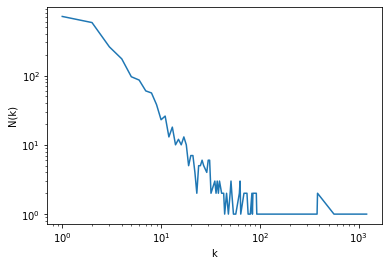

In [9]:
# This code generates a degree distribution of a bipartite graph, where one set of vertices represents metabolites 
# and the other set represents reactions. The code first separates the vertex names into two sets, one for metabolites
# and one for reactions. The code then selects only the metabolite vertex indices and calculates the degree of each 
# metabolite vertex. It then plots the log-log degree distribution of the metabolites, where the x-axis is the degree 
# and the y-axis is the number of metabolites with that degree. The degree of a vertex in a graph is the number of 
# edges connected to it.

vertex_names = bipartite_graph.vs["name"]

# Create a set of vertex names that correspond to reactions in the bipartite graph
reaction_names_set = set([vertex_name for vertex_name in vertex_names if "REACTION" in vertex_name])

# Create a list of vertex names that correspond to metabolites in the bipartite graph
metabolite_names = [vertex_name for vertex_name in vertex_names if not (vertex_name in reaction_names_set)] 

# Create a set of metabolite names
metabolite_names_set = set(metabolite_names)

# Get the indices of the metabolite vertices in the bipartite graph
metabolite_inds = [i for i, vn in enumerate(vertex_names) if vn in metabolite_names_set]

# Calculate the degree of each metabolite vertex
metabolite_degrees = bipartite_graph.degree(metabolite_inds)

# Plot the log-log degree distribution of the metabolites, where xs is the degree and ys is the number of metabolites
# with that degree
xs, ys = zip(*[(left, count) for left, _, count in
              bipartite_graph.degree_distribution(vertices=metabolite_inds).bins() if count > 0])
plt.loglog(xs, ys)
plt.xlabel("k")
plt.ylabel("N(k)")
plt.show()


Question: *what is the exponent α of the best-fit power-law to the degree distribution?* 

(hint: use `igraph.statistics.power_law_fit`)

In [10]:
# Estimate the alpha value of the degree distribution of the bipartite graph
alpha = igraph.statistics.power_law_fit((bipartite_graph.degree())).alpha

# Print the estimated alpha value with 2 decimal places
print("%.2f"%alpha)

2.03



---



Questions to answer: *How does the α that you get compare to the estimate of the power-law exponent reported by Jeong et al. in their 2000 article in Nature, “The large-scale organization of metabolic networks” (vol. 407, pp. 651–654) (see page 14 of reading-for-class-06.pdf)? Based on structure of the network that you analyzed (bipartite, containing reactions) vs. the structure of the network that they analyzed (network projected to a network containing only metabolites), is it appropriate to compare the exponents? Why or why not?*

(You may also find page 12 of the supplementary material for the Jeong et al. article useful; that can be found [here](https://canvas.oregonstate.edu/courses/1793772/files/folder/Optional%20Reading?preview=80988163)).

**The alpha of 2.03 is high for this metabolic netwrok incomparision of the results presented in figure 3 from Jeong et al, 2000.**


Task:  *Calculate the shortest-path-lengths between all pairs of metabolites (vertices) in the giant weakly connected component of the graph, discarding direction information in the graph.*  

(hint: use `clusters` with `mode=weak` to get the giant weakly-connected component; then use `components.membership` and `enumerate` to get the giant component members; then use `igraph.Graph.shortest_paths` with `mode=igraph.ALL`, with
`source=<metabolite_vertex_indices>` and `target=<metabolite_vertex_indices>` to get the
all-pairs-shortest-paths.)

In [11]:
# Get the weakly-connected component of the bipartite graph
g_components = bipartite_graph.clusters(mode='weak')

# Get the size of the components by calculating the length of each component
g_component_size = g_components

# Find the maximum size of the components using numpy's max function
np.max(g_component_size)

<ipython-input-11-16aca2a62331>:2: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  g_components = bipartite_graph.clusters(mode='weak')
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[7742, 7743, 7744]

In [12]:
# Find the weakly connected components of the graph
g_components = bipartite_graph.clusters(mode='weak')

# Get the membership of each vertex in the components
g_component_ids = g_components.membership

# Get the vertex index for each vertex in the graph
component_ids = [vertex_index for vertex_index, g_component_id in enumerate(g_component_ids)]

# Get the names of the vertices in the graph that belong to the weakly connected components
vertex_names = bipartite_graph.vs(component_ids)["name"]
print(vertex_names)

['alkylated DNA', 'REACTION1', 'DNAn', 'alkylated nucleobase', 'acetyl-CoA', 'REACTION2', '1-alkyl-2-lyso-sn-glycero-3-phosphocholine', '1-alkyl-2-acetyl-sn-glycero-3-phosphocholine', 'coenzyme A', 'deoxyribonucleoside triphosphate', 'REACTION3', '(deoxynucleotides)(n)', '(deoxynucleotides)(n+1)', 'diphosphate', "N,N'-diacetylchitobiose", 'REACTION4', 'N-acetyl-D-glucosamine', 'alcohol', 'REACTION5', "3'-phosphoadenylyl-sulfate", "adenosine 3',5'-bisphosphate", 'organosulfate', '(20S)-17,20-dihydroxypregn-4-en-3-one', 'REACTION6', 'NAD(P)+', '17-alpha-hydroxyprogesterone', 'NAD(P)H', '[lipoyl-carrier protein] N6-octanoyl-L-lysine', 'REACTION7', 'S-adenosyl-L-methionine', 'sulfurated [sulfur carrier]', 'reduced [2Fe-2S] ferredoxin', '[lipoyl-carrier protein] N6-lipoyl-L-lysine', "5'-deoxyadenosine", 'L-methionine', 'unsulfurated [sulfur carrier]', 'oxidized [2Fe-2S] ferredoxin', 'L-thyroxine', 'REACTION8', 'UDP-alpha-D-glucuronate', 'L-thyroxine phenolic beta-D-glucuronide', 'UDP', '[de

<ipython-input-12-1b612e3b998f>:2: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  g_components = bipartite_graph.clusters(mode='weak')


In [13]:
#then use igraph.Graph.shortest_paths with mode=igraph.ALL, with source=<metabolite_vertex_indices> and target=<metabolite_vertex_indices> to get the all-pairs-shortest-paths.)
#def shortest_paths(source=None, target=None, weights=None, mode='out'): 

short_path = [bipartite_graph.shortest_paths(source=metabolite_inds, target=metabolite_inds, mode=igraph.ALL)]


<ipython-input-13-6ff8c0be05ba>:4: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  short_path = [bipartite_graph.shortest_paths(source=metabolite_inds, target=metabolite_inds, mode=igraph.ALL)]


Question: *What is the average of the shortest-path-lengtsh between all pairs of metabolites in the giant (weakly connected) component of the network?*

 

(hint: Use `numpy.array`, `numpy.isfinite` and `numpy.mean` to get the mean distance; throw away any shortest-paths distance value if it is infinite.)


In [14]:
# Create a numpy array from a list object 'short_path'
np_short_path = np.array(short_path)

# Calculate the mean of the elements in np_short_path
# Only elements with finite values (i.e., not NaN, inf, or -inf) are included in the calculation
mean = np.mean(np_short_path[(np.isfinite(np_short_path))])

# Print the mean value with 2 decimal places
print("%.2f"%mean)

6.79


Question: *What is the maximum of the shortest-path-length between all pairs of metabolites (throwing away infinite values, as before) in the giant (weakly connected) component of the network?* 

(hint: use `numpy.max` and `numpy.isfinite`; Note, you are calculating the diameter of the giant component)

In [15]:
# Calculate the maximum of the elements in np_short_path
# Only elements with finite values (i.e., not NaN, inf, or -inf) are included in the calculation
max = np.max(np_short_path[(np.isfinite(np_short_path))])

# Print the maximum value with 0 decimal places
print("%.0f"%max)

18


# Question:  Why are the average geodesic distances that we get, roughly twice those reported in Fig. 3b of Jeong et al., 2000?

:Calculate the shortest-paths betweenness centrality for all metabolites in the directed network.  (hint: use the `betweenness` function with the `vertices=<vector of vertex indices>` option, with `directed=True`)

In [16]:
# Calculate the betweenness centrality of the graph
# directed=True means the graph is a directed graph
# vertices=metabolite_inds specifies that only the vertices with indices in the list metabolite_inds will be considered
between = bipartite_graph.betweenness(directed=True, vertices=metabolite_inds)

# Print the first 20 elements of the betweenness centrality
print(between[0:20])


[0.0, 21.999999999999996, 0.0, 3320235.0815159036, 7096.381133853538, 29104.5, 6005936.978443008, 0.0, 0.0, 0.0, 2338690.7735337936, 6.0, 0.0, 175962.55149347777, 614936.2341288251, 596406.7936343277, 0.0, 0.0, 1109132.5890637527, 19280.96464791662]


Task: *plot the scatter plot of betweenness centrality vs. vertex degree for all metabolites, on log-log scale.*  (In the plot, normalize your betweenness centrality values by dividing by M^2 where M is the number of metabolites.)

(hint:  use `numpy.array`, `numpy.where`, and `matplotlib.pyplot.scatter`)

In [17]:
# (In the plot, normalize your betweenness centrality values by dividing by M^2 where M is the number of metabolites.)
# Initialize an empty list to store the normalized betweenness centrality
norm_between = []

# Calculate the normalization factor
norm_factor = (len(meta_set))**2

# Normalize the betweenness centrality by dividing each value by the normalization factor
for i in between:
  norm_between.append(i/norm_factor)

In [18]:
#removes zero values prior to log transormation
# Initialize two empty lists to store the x and y values for the log-transformed data
ybd = []
xbd = []

# Initialize a counter variable
counter = int(0)

# Loop through the list of normalized betweenness centrality values
while (counter < 2340):
  for nb in norm_between:
      d = metabolite_degrees[counter]
      # Only append the values if the normalized betweenness centrality is greater than 0
      if(nb > 0):
         ybd.append(nb)
         xbd.append(d)
         counter += 1
      # If the normalized betweenness centrality is not greater than 0, move on to the next value
      else:
        counter += 1

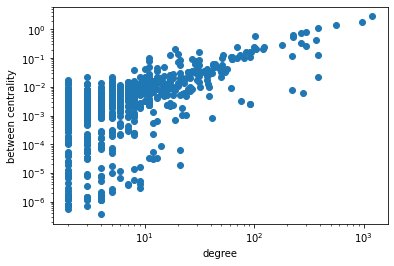

In [19]:
#plot the scatter plot of betweenness centrality vs. vertex degree for all metabolites, on log-log scale.

# Plot a scatter graph of between centrality vs degree
plt.gca().scatter(xbd, ybd)

# Set the x-axis to be logarithmic scale
plt.gca().set_xscale("log")

# Set the y-axis to be logarithmic scale
plt.gca().set_yscale("log")

# Set the x-axis label to "degree"
plt.xlabel("degree")

# Set the y-axis label to "between centrality"
plt.ylabel("between centrality")

# Show the plot
plt.show()

Question: *Among metabolites with degree k=2 , what metabolite has highest betweenness centrality in the network?* 

(hint:  use `numpy.argmax` and `numpy.where`

In [20]:
print)

SyntaxError: ignored

In [ ]:
#This code is using Numpy to calculate the betweenness centrality of a bipartite graph
#The first step is to combine the metabolite degrees, indices, and betweenness values into a single array
combined_ar = np.array(list(zip(metabolite_degrees,metabolite_inds,between)))

#Then, the code is selecting all the rows in the array where the degree of the metabolite is equal to 2
degree_k2 = np.where(combined_ar[:,0]== 2) #ndarray with shape (581,)

#The selected rows are assigned to the variable `degree_k2_ar`
degree_k2_ar = combined_ar[degree_k2]

#Then the code is selecting only the betweenness centrality values of the selected rows
degree_k2_ar = degree_k2_ar[:,2]

#Next, the code finds the index of the row in `degree_k2_ar` that has the highest betweenness centrality
max_ind = np.argmax(degree_k2_ar)#345

#The highest betweenness centrality value is stored in the variable `degree_K2_max`
degree_K2_max = degree_k2_ar[max_ind]#98120.21403178881

#The code then finds the index of the row in the original `combined_ar` array that has the highest betweenness centrality
ind_deg2_betmax = np.where(combined_ar[:,2]== degree_K2_max)

#Then the code iterates through the list of indices and assigns the first index to the variable `ind_deg2_betmax`
for i in ind_deg2_betmax:
  for x in i:
    ind_deg2_betmax=x

#Finally, the code retrieves the name of the vertex from the bipartite graph that corresponds to the index with the highest betweenness centrality
bipartite_graph.vs(metabolite_inds[ind_deg2_betmax])["name"]

Search on this metabolite in the HumanCyc database at [humancyc.org](https://humancyc.org), using the "Quick Search" box. Click on the hyperlinked metabolite that is displayed on the search results page. Click on the "reactions" tab, in the tabbed window in the lower part of the page. 

What important metabolic cycles is this metabolite involved in? 

**L-aspartate + L-citrulline + ATP → L-arginino-succinate + AMP + diphosphate + H+**


Click on the "urea cycle". What is the known consequence of absence of an enzyme in this pathway?

**Abcsences of any of the five key enzymes in the urea cycle associated with the productions of L-arginino-succinate & AMP are lethal due to liver faliure cuased by hyperammonemia**